**Melanoma** **Detection** **Assignment**

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## Mount the data to google drive by using following code :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Test')

In [5]:
#Count of the images in Train and Test sets
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load images from dataset using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
#Given below is the batch size and image specification to resize images
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note: use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Names of the classes of skin cancer in a list. 
# You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

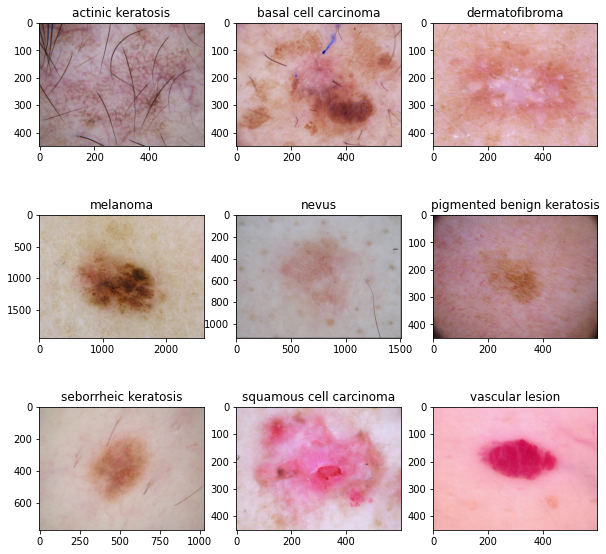

In [10]:
# You can use training or validation data to visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()`: It keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()`: It overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Create Model:
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
# Model built from Raw dataset
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 840s 3s/step - loss: 2.1029 - accuracy: 0.1964 - val_loss: 2.0396 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 5s 80ms/step - loss: 2.0335 - accuracy: 0.1987 - val_loss: 2.0320 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 4s 78ms/step - loss: 2.0057 - accuracy: 0.2232 - val_loss: 1.9966 - val_accuracy: 0.2394
Epoch 4/20
56/56 [==============================] - 4s 78ms/step - loss: 1.9823 - accuracy: 0.2310 - val_loss: 1.9682 - val_accuracy: 0.1991
Epoch 5/20
56/56 [==============================] - 4s 77ms/step - loss: 1.9516 - accuracy: 0.2595 - val_loss: 2.0045 - val_accuracy: 0.2349
Epoch 6/20
56/56 [==============================] - 4s 77ms/step - loss: 1.9717 - accuracy: 0.2416 - val_loss: 1.9858 - val_accuracy: 0.2371
Epoch 7/20
56/56 [==============================] - 4s 77ms/step - loss: 1.9795 - accuracy: 0.2494 - val_loss: 1.9535 - val_accuracy: 0.2528
Epoch 8/20
56

### Visualizing training results

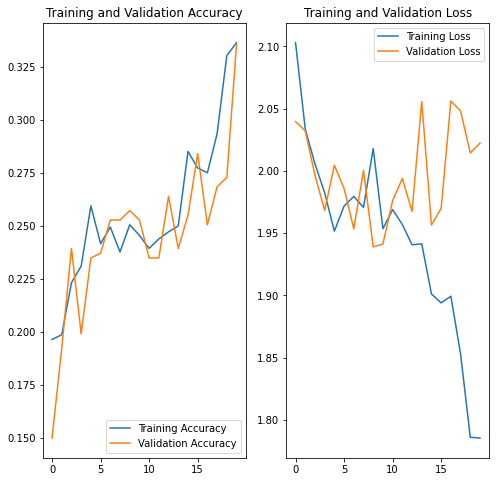

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit



**Findings on the first base model**

- The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch

- The accuracy is around 75-80% because there are enough features to remember the pattern.

- But again, it's too early to comment on the overfitting & underfitting debate



In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

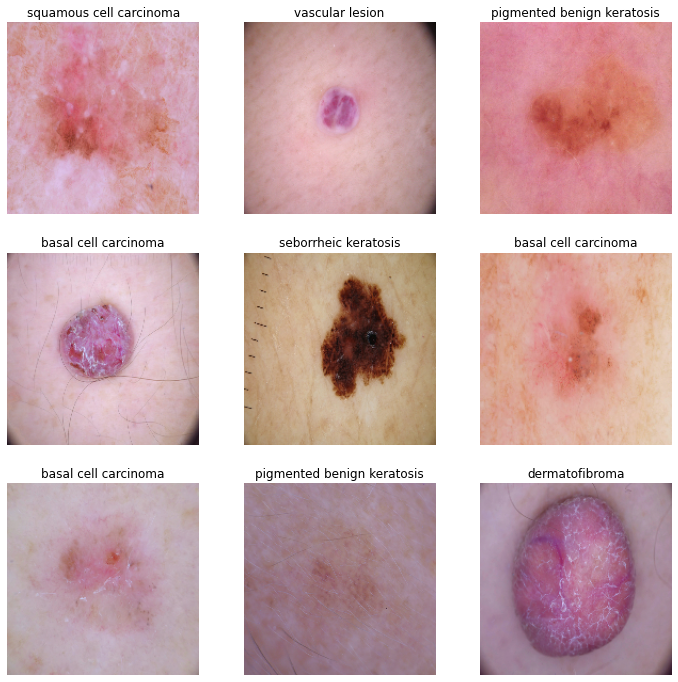

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
#second model built from a rectified datset
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compiling the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [21]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 92ms/step - loss: 2.0678 - accuracy: 0.1931 - val_loss: 2.0325 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 5s 88ms/step - loss: 1.8783 - accuracy: 0.3019 - val_loss: 1.7671 - val_accuracy: 0.3445
Epoch 3/20
56/56 [==============================] - 5s 86ms/step - loss: 1.7656 - accuracy: 0.3432 - val_loss: 1.6673 - val_accuracy: 0.3960
Epoch 4/20
56/56 [==============================] - 5s 87ms/step - loss: 1.6267 - accuracy: 0.4124 - val_loss: 1.5859 - val_accuracy: 0.4631
Epoch 5/20
56/56 [==============================] - 5s 87ms/step - loss: 1.6111 - accuracy: 0.4118 - val_loss: 1.5483 - val_accuracy: 0.4720
Epoch 6/20
56/56 [==============================] - 5s 87ms/step - loss: 1.6358 - accuracy: 0.4185 - val_loss: 1.7368 - val_accuracy: 0.3781
Epoch 7/20
56/56 [==============================] - 5s 90ms/step - loss: 1.5436 - accuracy: 0.4587 - val_loss: 1.5172 - val_accuracy: 0.4452
Epoch 8/20
56

### Visualizing the results

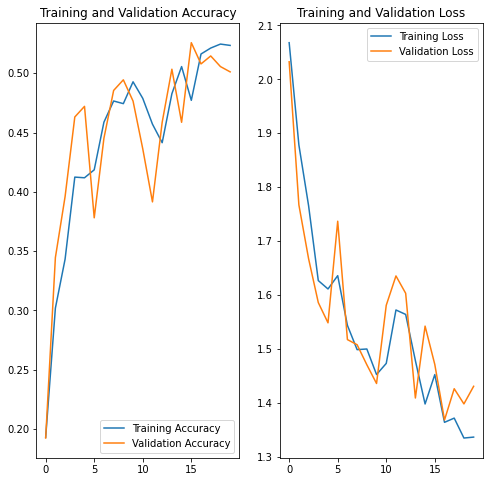

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Finding from Second Model**

- There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation 

- We can increase the epochs to increase the accuracy so it's too early for judgement 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
1,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
2,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
3,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
4,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Colab Notebooks/Train/v...,vascular lesion
2235,/content/drive/MyDrive/Colab Notebooks/Train/v...,vascular lesion
2236,/content/drive/MyDrive/Colab Notebooks/Train/v...,vascular lesion
2237,/content/drive/MyDrive/Colab Notebooks/Train/v...,vascular lesion


In [24]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
1,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
2,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
3,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
4,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Colab Notebooks/Train/v...,vascular lesion
2235,/content/drive/MyDrive/Colab Notebooks/Train/v...,vascular lesion
2236,/content/drive/MyDrive/Colab Notebooks/Train/v...,vascular lesion
2237,/content/drive/MyDrive/Colab Notebooks/Train/v...,vascular lesion


<BarContainer object of 9 artists>

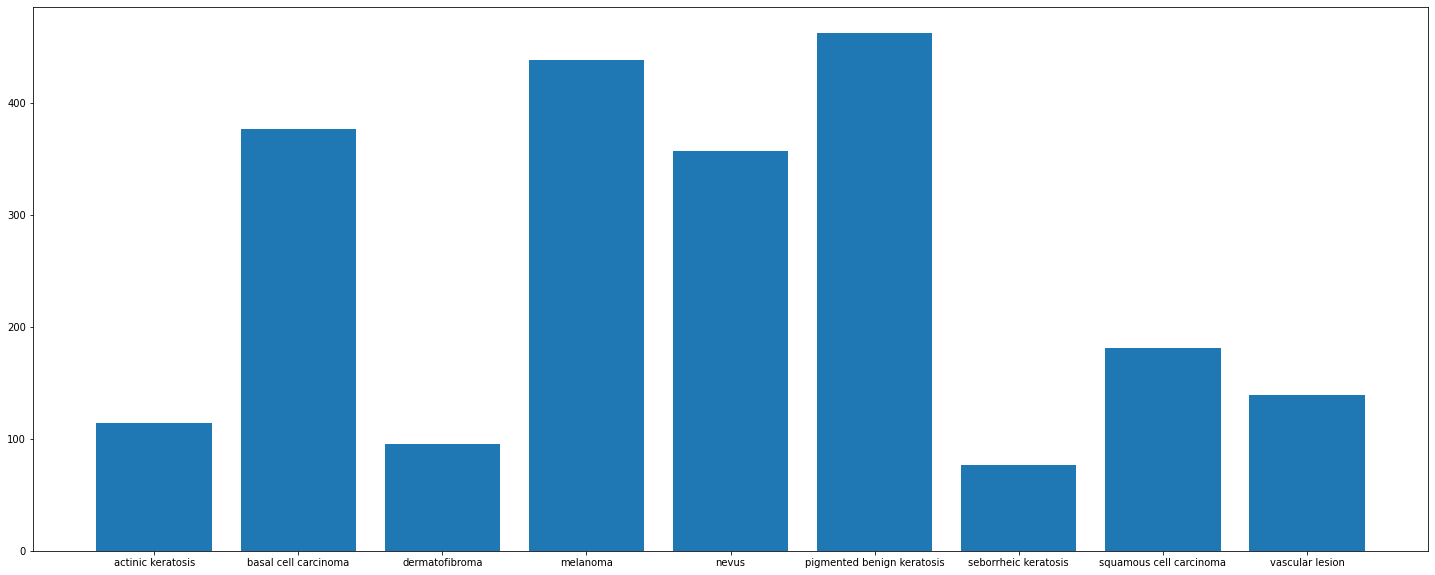

In [25]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least and the maximum number of samples?
#### ***Answer-***1 :- serborric keratosis cell has least number of samples and pigmented benign keratosis has the maximum number of samples.
#### - Which classes dominate the data in terms proportionate number of samples?
#### ***Answer-2***:- actinic keratosis and dermatofibroma have proportionate number of classes. melanoma and pigmented benign keratosis have proprtionate number of classes


In [26]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/drive/MyDrive/Colab Notebooks/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F15D65335D0>: 100%|██████████| 500/500 [00:56<00:00,  8.79 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F15D98F1DD0>: 100%|██████████| 500/500 [00:37<00:00, 13.42 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=963x629 at 0x7F15D8F4B890>: 100%|██████████| 500/500 [00:40<00:00, 12.20 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F15D97CA990>: 100%|██████████| 500/500 [00:44<00:00, 11.23 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F15D98A8310>: 100%|██████████| 500/500 [00:46<00:00, 10.79 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F15D7DF0A90>: 100%|██████████| 500/500 [00:47<00:00, 10.62 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7F15D6543290>: 100%|██████████| 500/500 [00:44<00:00, 11.26 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F15D9981250>: 100%|██████████| 500/500 [00:40<00:00, 12.36 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F15D8F01C50>: 100%|██████████| 500/500 [00:48<00:00, 10.24 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
data_dir_train1 = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


In [30]:
for i in class_names:   
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
1,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
2,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
3,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
4,/content/drive/MyDrive/Colab Notebooks/Train/a...,actinic keratosis
...,...,...
6734,/content/drive/MyDrive/Colab Notebooks/Train/o...,vascular lesion
6735,/content/drive/MyDrive/Colab Notebooks/Train/o...,vascular lesion
6736,/content/drive/MyDrive/Colab Notebooks/Train/o...,vascular lesion
6737,/content/drive/MyDrive/Colab Notebooks/Train/o...,vascular lesion


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
new_df['Label'].value_counts()

pigmented benign keratosis    1375
melanoma                      1315
basal cell carcinoma          1121
nevus                         1117
squamous cell carcinoma        559
vascular lesion                415
actinic keratosis              344
dermatofibroma                 276
seborrheic keratosis           217
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

In [33]:
import pathlib
data_dir_train1=pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Train")

In [34]:
data_dir_train1

PosixPath('/content/drive/MyDrive/Colab Notebooks/Train')

#### **Todo:** Create a training dataset

In [35]:
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

2239


In [36]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_dir_train1=pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [38]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# Model built from Augmented Dataset
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [40]:
epochs =30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 43s 241ms/step - loss: 2.5126 - accuracy: 0.6625 - val_loss: 2.3208 - val_accuracy: 0.6726
Epoch 2/30
169/169 [==============================] - 34s 197ms/step - loss: 2.1512 - accuracy: 0.6665 - val_loss: 2.3202 - val_accuracy: 0.6726
Epoch 3/30
169/169 [==============================] - 32s 185ms/step - loss: 2.0815 - accuracy: 0.6665 - val_loss: 2.2077 - val_accuracy: 0.6726
Epoch 4/30
169/169 [==============================] - 32s 183ms/step - loss: 3.7939 - accuracy: 0.4026 - val_loss: 5.5452 - val_accuracy: 0.0230
Epoch 5/30
169/169 [==============================] - 34s 194ms/step - loss: 5.5452 - accuracy: 0.0154 - val_loss: 5.5452 - val_accuracy: 0.0230
Epoch 6/30
169/169 [==============================] - 34s 193ms/step - loss: 5.5452 - accuracy: 0.0154 - val_loss: 5.5452 - val_accuracy: 0.0230
Epoch 7/30
169/169 [==============================] - 33s 187ms/step - loss: 5.5452 - accuracy: 0.0154 - val_loss: 5.5452 - val_ac

#### **Todo:**  Visualize the model results

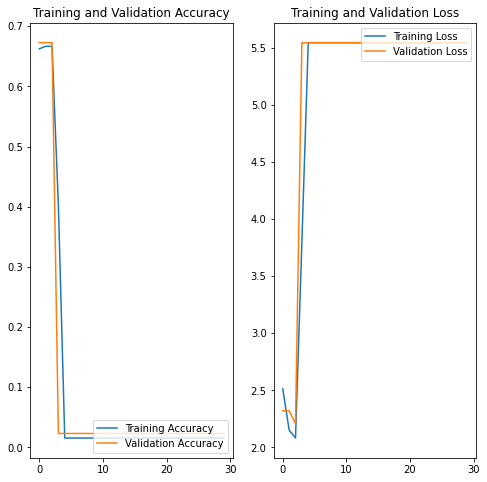

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Conclusion



- Accuracy on training data has increased by using Augmentor library

- Model is still overfitting

- The problem of overfitting can be solved by add more layer, neurons or adding dropout layers.

- The Model can be further improved by tuning the hyperparameter